# Monocular depth estimation - Recursive models
## Kiwibot entry project - Sebastián Hernández Reyes

Following we experimented with a DephtNet model, that is a modified U-Net with Conv-LSTM layers to take into account time in the variations of the dataset


In [1]:
# Imports
import os
import random

import imageio.v2 as imageio
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from skimage import io

import typing as ty
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torchmetrics
from torchmetrics.functional import image_gradients
from torchmetrics.functional import structural_similarity_index_measure
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

import neptune.new as neptune

In [2]:
# Check if PyTorch has GPU available
print('Pytorch GPU Available:', torch.cuda.is_available())

Pytorch GPU Available: True


In [3]:
# Global Configurations
PROJECT_PATH = 'D:\Documents\Kiwibot\depth-estimation-project'
USEFUL_CAMERAS = [['/video_mapping/left','/video_mapping/left/depth_map'],['/video_mapping/right', '/video_mapping/right/depth_map'], ['/video_mapping/back', '/video_mapping/back/depth_map'],['/camera/color/image_raw', '/camera/color/image_raw/depth_map']]
NEPTUNE_TOKEN = "eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIxMDQ1OWE3Yy0zMzA3LTQzY2ItYmFlOS02YzRjZGY3NGRlZmMifQ=="

In [4]:
metadata_path = os.path.join(PROJECT_PATH,'data','metadata.csv')
metadata = pd.read_csv(metadata_path, encoding='utf-8')
metadata = metadata.sort_values(by=['timestamp'])
metadata.head()

,/video_mapping/left,/video_mapping/right,/camera/color/image_raw,/video_mapping/back,pos_x,pos_y,pos_z,quat_x,quat_y,quat_z,...,timestamp,/video_mapping/back/depth_map,/video_mapping/right/depth_map,/video_mapping/left/depth_map,/camera/color/image_raw/depth_map,lat,lon,roll,pitch,yaw
15258,video_mapping_left_image_1642030268620.jpg,video_mapping_right_image_1642030268636.jpg,camera_color_image_raw_image_1642030268655.jpg,video_mapping_back_image_1642030268717.jpg,71.830883,-101.936200,0.0,0.008512,-0.031057,-0.223881,...,1642030268662,video_mapping_back_depth_map_1642030268662.png,video_mapping_right_depth_map_1642030268662.png,video_mapping_left_depth_map_1642030268662.png,camera_color_image_raw_depth_map_1642030268662...,33.956484,-118.431755,0.027271,-0.165806,-0.801761
15259,video_mapping_left_image_1642030269035.jpg,video_mapping_right_image_1642030269081.jpg,camera_color_image_raw_image_1642030269055.jpg,video_mapping_back_image_1642030269093.jpg,72.052666,-102.044261,0.0,0.006728,-0.031237,-0.226046,...,1642030269057,video_mapping_back_depth_map_1642030269057.png,video_mapping_right_depth_map_1642030269057.png,video_mapping_left_depth_map_1642030269057.png,camera_color_image_raw_depth_map_1642030269057...,33.956482,-118.431751,0.035997,-0.147262,-0.775581
15260,video_mapping_left_image_1642030269227.jpg,video_mapping_right_image_1642030269237.jpg,camera_color_image_raw_image_1642030269188.jpg,video_mapping_back_image_1642030269266.jpg,72.193947,-102.114457,0.0,0.006160,-0.033374,-0.228125,...,1642030269234,video_mapping_back_depth_map_1642030269234.png,video_mapping_right_depth_map_1642030269234.png,video_mapping_left_depth_map_1642030269234.png,camera_color_image_raw_depth_map_1642030269234...,33.956482,-118.431751,0.035997,-0.147262,-0.775581
15261,video_mapping_left_image_1642030269641.jpg,video_mapping_right_image_1642030269671.jpg,camera_color_image_raw_image_1642030269655.jpg,video_mapping_back_image_1642030269710.jpg,72.384768,-102.208700,0.0,0.004136,-0.031127,-0.220275,...,1642030269657,video_mapping_back_depth_map_1642030269657.png,video_mapping_right_depth_map_1642030269657.png,video_mapping_left_depth_map_1642030269657.png,camera_color_image_raw_depth_map_1642030269657...,33.956481,-118.431748,0.032725,-0.148353,-0.749401
15262,video_mapping_left_image_1642030269837.jpg,video_mapping_right_image_1642030269862.jpg,camera_color_image_raw_image_1642030269855.jpg,video_mapping_back_image_1642030269899.jpg,72.513514,-102.269331,0.0,0.004372,-0.027809,-0.218750,...,1642030269853,video_mapping_back_depth_map_1642030269853.png,video_mapping_right_depth_map_1642030269853.png,video_mapping_left_depth_map_1642030269853.png,camera_color_image_raw_depth_map_1642030269853...,33.956481,-118.431748,0.032725,-0.148353,-0.749401


## Metrics

For the evaluation of models, the following evaluation metrics were chosen:
* Absolute relative difference (MAE)
* Root Mean Squared Log Error (RMSLE)
* Prediction Time

## Data Pipeline

### Pytorch Data Pipeline

In [5]:
images_dir = os.path.join(PROJECT_PATH,'data','lidar-cams-dataset')

In [6]:
class TimedLidarDepthDataset(Dataset):

    def __init__(self, csv_file, images_dir, window=2, transform=None):

        columns = [item for sublist in USEFUL_CAMERAS for item in sublist] + ['timestamp']
        self.metadata = pd.read_csv(csv_file, encoding='utf-8')
        self.metadata = self.metadata.sort_values(by=['timestamp'])[columns]
        self.images_dir = images_dir
        self.window = window
        self.transform = transform

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        if type(idx) == int:
            idx = [idx]

        data_len = len(self.metadata)-3

        idx_np = np.array(idx)
        new_idx = np.empty([len(idx_np),2], dtype=int)

        new_idx[:,0] = idx_np // data_len
        new_idx[:,1] = idx_np % data_len

        img_names = []
        map_names = []

        for j in range(self.window):
            column_image = 2 * new_idx[0,0] # Camera columns are even in dataset
            column_map = 2 * new_idx[0,0] + 1 # Maps are odds
            row_idx = new_idx[0,1] + j

            img_names.append(os.path.join(self.images_dir,self.metadata.iloc[row_idx, column_image]))
            map_names.append(os.path.join(self.images_dir,self.metadata.iloc[row_idx, column_map]))

        img_names.reverse()
        map_names.reverse()

        images_np = np.array([])
        for img_path in img_names:
            image = io.imread(img_path)
            image = image / 255
            image = np.expand_dims(image,0)
            images_np = np.vstack([images_np, image]) if images_np.size else image

        depth_maps_np = np.array([])
        for map_path in map_names:
            depth_map = np.array(imageio.imread(map_path)).astype(float)
            depth_map = depth_map / depth_map.max()
            depth_map = np.expand_dims(depth_map,0)
            depth_maps_np = np.vstack([depth_maps_np, depth_map]) if depth_maps_np.size else depth_map

        sample = {'image': images_np, 'depth_map': depth_maps_np}

        if self.transform:
            sample = self.transform(sample)

        return sample

    def __len__(self):
        return (len(self.metadata)-3)*4-1

In [7]:
dataset = TimedLidarDepthDataset(metadata_path,images_dir)

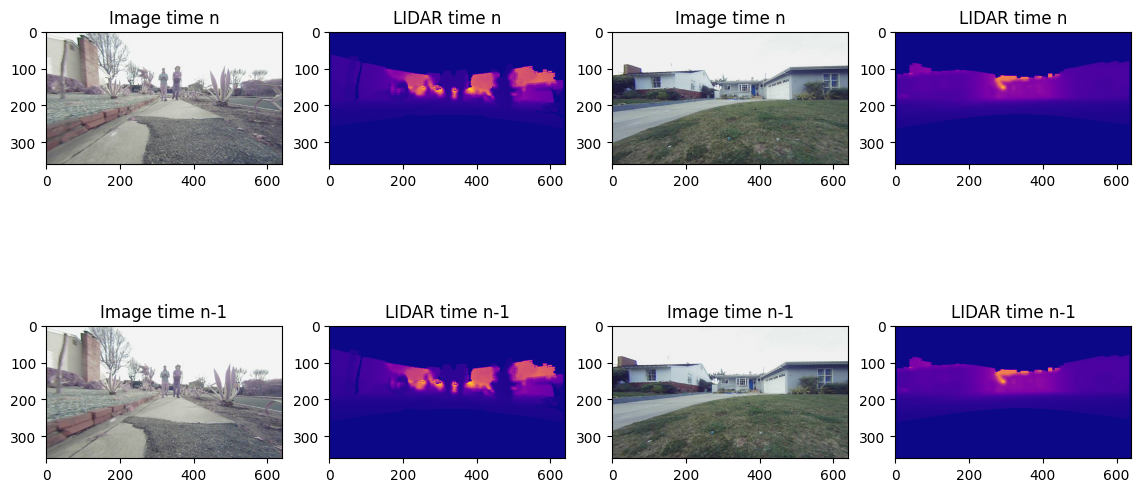

In [8]:
fig, ax = plt.subplots(2, 4, figsize=(14, 7))

for i in range(2):
    N = random.randint(0, len(dataset))
    sample = dataset.__getitem__(N)
    images = sample['image']
    maps = sample['depth_map']

    ax[0,2*i].imshow(images[0])
    ax[0,2*i].set_title('Image time n')
    ax[1,2*i].imshow(images[1])
    ax[1,2*i].set_title('Image time n-1')

    ax[0,2*i+1].imshow(maps[0].squeeze(), cmap='plasma')
    ax[0,2*i+1].set_title('LIDAR time n')
    ax[1,2*i+1].imshow(maps[0].squeeze(), cmap='plasma')
    ax[1,2*i+1].set_title('LIDAR time n-1')

plt.show()

In [9]:
# Transformations
class Resize(object):
    """Resize sample to given size (width, height).
    """

    def __init__(
            self,
            width,
            height,
            resize_target=True,
            keep_aspect_ratio=False,
            ensure_multiple_of=1,
            resize_method="lower_bound",
            image_interpolation_method=cv2.INTER_AREA,
    ):
        """Init.
        Args:
            width (int): desired output width
            height (int): desired output height
            resize_target (bool, optional):
                True: Resize the full sample (image, depth_map, target).
                False: Resize image only.
                Defaults to True.
            keep_aspect_ratio (bool, optional):
                True: Keep the aspect ratio of the input sample.
                Output sample might not have the given width and height, and
                resize behaviour depends on the parameter 'resize_method'.
                Defaults to False.
            ensure_multiple_of (int, optional):
                Output width and height is constrained to be multiple of this parameter.
                Defaults to 1.
            resize_method (str, optional):
                "lower_bound": Output will be at least as large as the given size.
                "upper_bound": Output will be at max as large as the given size. (Output size might be smaller than given size.)
                "minimal": Scale as least as possible.  (Output size might be smaller than given size.)
                Defaults to "lower_bound".
        """
        self.__width = width
        self.__height = height

        self.__resize_target = resize_target
        self.__keep_aspect_ratio = keep_aspect_ratio
        self.__multiple_of = ensure_multiple_of
        self.__resize_method = resize_method
        self.__image_interpolation_method = image_interpolation_method

    def constrain_to_multiple_of(self, x, min_val=0, max_val=None):
        y = (np.round(x / self.__multiple_of) * self.__multiple_of).astype(int)

        if max_val is not None and y > max_val:
            y = (np.floor(x / self.__multiple_of) * self.__multiple_of).astype(int)

        if y < min_val:
            y = (np.ceil(x / self.__multiple_of) * self.__multiple_of).astype(int)

        return y

    def get_size(self, width, height):
        # determine new height and width
        scale_height = self.__height / height
        scale_width = self.__width / width

        if self.__keep_aspect_ratio:
            if self.__resize_method == "lower_bound":
                # scale such that output size is lower bound
                if scale_width > scale_height:
                    # fit width
                    scale_height = scale_width
                else:
                    # fit height
                    scale_width = scale_height
            elif self.__resize_method == "upper_bound":
                # scale such that output size is upper bound
                if scale_width < scale_height:
                    # fit width
                    scale_height = scale_width
                else:
                    # fit height
                    scale_width = scale_height
            elif self.__resize_method == "minimal":
                # scale as least as possbile
                if abs(1 - scale_width) < abs(1 - scale_height):
                    # fit width
                    scale_height = scale_width
                else:
                    # fit height
                    scale_width = scale_height
            else:
                raise ValueError(
                    f"resize_method {self.__resize_method} not implemented"
                )

        if self.__resize_method == "lower_bound":
            new_height = self.constrain_to_multiple_of(
                scale_height * height, min_val=self.__height
            )
            new_width = self.constrain_to_multiple_of(
                scale_width * width, min_val=self.__width
            )
        elif self.__resize_method == "upper_bound":
            new_height = self.constrain_to_multiple_of(
                scale_height * height, max_val=self.__height
            )
            new_width = self.constrain_to_multiple_of(
                scale_width * width, max_val=self.__width
            )
        elif self.__resize_method == "minimal":
            new_height = self.constrain_to_multiple_of(scale_height * height)
            new_width = self.constrain_to_multiple_of(scale_width * width)
        else:
            raise ValueError(f"resize_method {self.__resize_method} not implemented")

        return (new_width, new_height)

    def __call__(self, sample):
        width, height = self.get_size(
            sample["image"].shape[2], sample["image"].shape[1]
        )

        window = sample['image'].shape[0]
        channels = sample['image'].shape[3]

        new_image = np.empty((window,width,height,channels))
        new_map = np.empty((window,width,height))

        for i in range(window):
            # resize sample
            new_image[i] = cv2.resize(
                sample["image"][i],
                (width, height),
                interpolation=self.__image_interpolation_method,
            )

            if self.__resize_target:

                if "depth_map" in sample:
                    new_map[i] = cv2.resize(
                        sample["depth_map"][i], (width, height), interpolation=cv2.INTER_NEAREST
                    )

        return {'image': new_image,
                'depth_map': new_map}


class PrepareForNet(object):
    """Prepare sample for usage as network input.
    """

    def __call__(self, sample):
        image = np.transpose(sample["image"], (0, 3, 1, 2))
        sample["image"] = torch.from_numpy(np.ascontiguousarray(image).astype(np.float32))

        if "depth_map" in sample:
            depth = sample["depth_map"].astype(np.float32)
            sample["depth_map"] = torch.from_numpy(np.ascontiguousarray(depth))

        return sample


class ApplyMask(object):
    """Get depth mask and image of the same size for usage as network input.
    """

    def __call__(self, sample):
        image, depth_map = sample['image'], sample['depth_map']
        mask = np.zeros_like(depth_map)
        mask[depth_map > 0] = 1
        mask_3 = np.stack((mask, mask, mask), axis=3)
        new_image = image * mask_3

        return {'image': new_image,
                'depth_map': depth_map}

In [10]:
transformed_dataset = TimedLidarDepthDataset(metadata_path, images_dir, transform=transforms.Compose([
    Resize(256, 256),
    ApplyMask(),
    PrepareForNet(),
]))

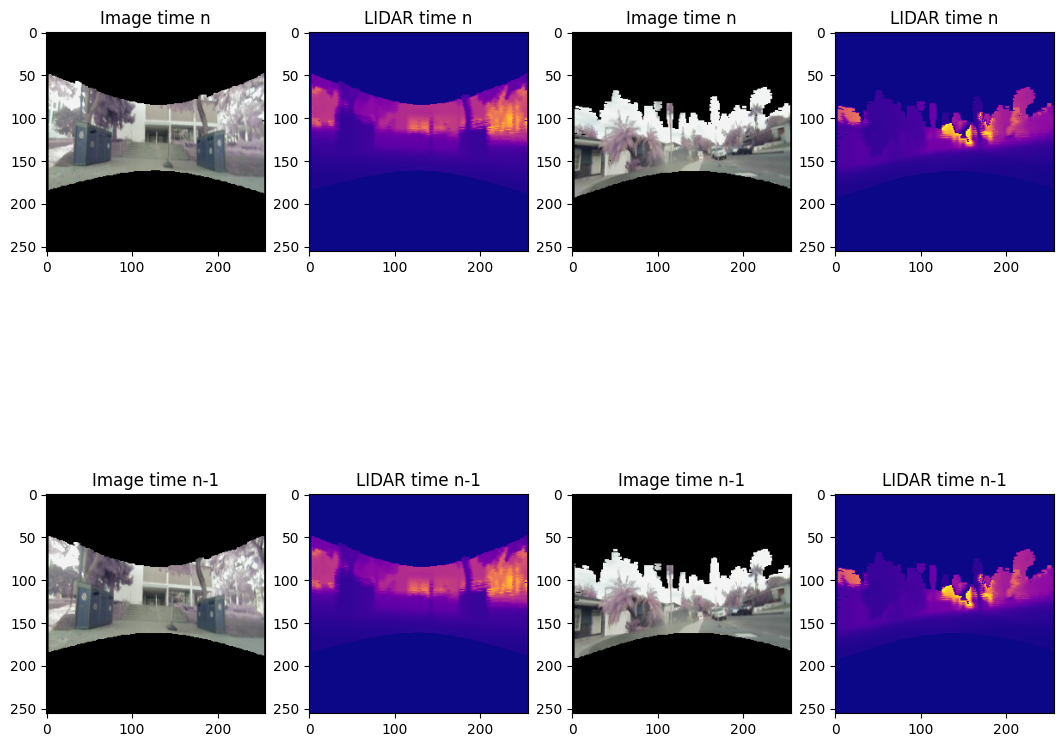

In [11]:
# Check out some images
fig, ax = plt.subplots(2, 4, figsize=(13, 11))


for i in range(2):
    N = random.randint(0, len(dataset))

    sample = transformed_dataset.__getitem__(N)
    images = sample['image']
    maps = sample['depth_map']

    ax[0,2*i].imshow(images[0].permute(1, 2, 0))
    ax[0,2*i].set_title('Image time n')
    ax[1,2*i].imshow(images[1].permute(1, 2, 0))
    ax[1,2*i].set_title('Image time n-1')

    ax[0,2*i+1].imshow(maps[0].squeeze(), cmap='plasma')
    ax[0,2*i+1].set_title('LIDAR time n')
    ax[1,2*i+1].imshow(maps[0].squeeze(), cmap='plasma')
    ax[1,2*i+1].set_title('LIDAR time n-1')

plt.show()

In [12]:
train_set, val_set, test_set = torch.utils.data.random_split(transformed_dataset, [25000, 3500,47823])
train_loader = DataLoader(train_set, batch_size=5, shuffle=True)
val_loader = DataLoader(val_set, batch_size=5, shuffle=True)
test_loader = DataLoader(test_set, batch_size=5, shuffle=True)

## Model Definition

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [14]:
# ConvLSTM Definition

class ConvLSTMCell(nn.Module):

    def __init__(self, input_dim, hidden_dim, kernel_size, bias):
        """
        Initialize ConvLSTM cell.
        Parameters
        ----------
        input_dim: int
            Number of channels of input tensor.
        hidden_dim: int
            Number of channels of hidden state.
        kernel_size: (int, int)
            Size of the convolutional kernel.
        bias: bool
            Whether or not to add the bias.
        """

        super(ConvLSTMCell, self).__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        self.kernel_size = kernel_size
        self.padding = kernel_size[0] // 2, kernel_size[1] // 2
        self.bias = bias

        self.conv = nn.Conv2d(in_channels=self.input_dim + self.hidden_dim,
                              out_channels=4 * self.hidden_dim,
                              kernel_size=self.kernel_size,
                              padding=self.padding,
                              bias=self.bias)

    def forward(self, input_tensor, cur_state):
        h_cur, c_cur = cur_state
        combined = torch.cat([input_tensor, h_cur], dim=1)  # concatenate along channel axis

        combined_conv = self.conv(combined)
        cc_i, cc_f, cc_o, cc_g = torch.split(combined_conv, self.hidden_dim, dim=1)
        i = torch.sigmoid(cc_i)
        f = torch.sigmoid(cc_f)
        o = torch.sigmoid(cc_o)
        g = torch.tanh(cc_g)

        c_next = f * c_cur + i * g
        h_next = o * torch.tanh(c_next)

        return h_next, c_next

    def init_hidden(self, batch_size, image_size):
        height, width = image_size
        return (torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device),
                torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device))


class ConvLSTM(nn.Module):

    """
    Parameters:
        input_dim: Number of channels in input
        hidden_dim: Number of hidden channels
        kernel_size: Size of kernel in convolutions
        num_layers: Number of LSTM layers stacked on each other
        batch_first: Whether or not dimension 0 is the batch or not
        bias: Bias or no bias in Convolution
        return_all_layers: Return the list of computations for all layers
        Note: Will do same padding.
    Input:
        A tensor of size B, T, C, H, W or T, B, C, H, W
    Output:
        A tuple of two lists of length num_layers (or length 1 if return_all_layers is False).
            0 - layer_output_list is the list of lists of length T of each output
            1 - last_state_list is the list of last states
                    each element of the list is a tuple (h, c) for hidden state and memory
    Example:
        >> x = torch.rand((32, 10, 64, 128, 128))
        >> convlstm = ConvLSTM(64, 16, 3, 1, True, True, False)
        >> _, last_states = convlstm(x)
        >> h = last_states[0][0]  # 0 for layer index, 0 for h index
    """

    def __init__(self, input_dim, hidden_dim, kernel_size, num_layers,
                 batch_first=False, bias=True, return_all_layers=False):
        super(ConvLSTM, self).__init__()

        self._check_kernel_size_consistency(kernel_size)

        # Make sure that both `kernel_size` and `hidden_dim` are lists having len == num_layers
        kernel_size = self._extend_for_multilayer(kernel_size, num_layers)
        hidden_dim = self._extend_for_multilayer(hidden_dim, num_layers)
        if not len(kernel_size) == len(hidden_dim) == num_layers:
            raise ValueError('Inconsistent list length.')

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.kernel_size = kernel_size
        self.num_layers = num_layers
        self.batch_first = batch_first
        self.bias = bias
        self.return_all_layers = return_all_layers

        cell_list = []
        for i in range(0, self.num_layers):
            cur_input_dim = self.input_dim if i == 0 else self.hidden_dim[i - 1]

            cell_list.append(ConvLSTMCell(input_dim=cur_input_dim,
                                          hidden_dim=self.hidden_dim[i],
                                          kernel_size=self.kernel_size[i],
                                          bias=self.bias))

        self.cell_list = nn.ModuleList(cell_list)

    def forward(self, input_tensor, hidden_state=None):
        """
        Parameters
        ----------
        input_tensor: todo
            5-D Tensor either of shape (t, b, c, h, w) or (b, t, c, h, w)
        hidden_state: todo
            None. todo implement stateful
        Returns
        -------
        last_state_list, layer_output
        """
        if not self.batch_first:
            # (t, b, c, h, w) -> (b, t, c, h, w)
            input_tensor = input_tensor.permute(1, 0, 2, 3, 4)

        b, _, _, h, w = input_tensor.size()

        # Implement stateful ConvLSTM
        if hidden_state is not None:
            raise NotImplementedError()
        else:
            # Since the init is done in forward. Can send image size here
            hidden_state = self._init_hidden(batch_size=b,
                                             image_size=(h, w))

        layer_output_list = []
        last_state_list = []

        seq_len = input_tensor.size(1)
        cur_layer_input = input_tensor

        for layer_idx in range(self.num_layers):

            h, c = hidden_state[layer_idx]
            output_inner = []
            for t in range(seq_len):
                h, c = self.cell_list[layer_idx](input_tensor=cur_layer_input[:, t, :, :, :],
                                                 cur_state=[h, c])
                output_inner.append(h)

            layer_output = torch.stack(output_inner, dim=1)
            cur_layer_input = layer_output

            layer_output_list.append(layer_output)
            last_state_list.append([h, c])

        if not self.return_all_layers:
            layer_output_list = layer_output_list[-1:]
            last_state_list = last_state_list[-1:]

        return layer_output_list, last_state_list

    def _init_hidden(self, batch_size, image_size):
        init_states = []
        for i in range(self.num_layers):
            init_states.append(self.cell_list[i].init_hidden(batch_size, image_size))
        return init_states

    @staticmethod
    def _check_kernel_size_consistency(kernel_size):
        if not (isinstance(kernel_size, tuple) or
                (isinstance(kernel_size, list) and all([isinstance(elem, tuple) for elem in kernel_size]))):
            raise ValueError('`kernel_size` must be tuple or list of tuples')

    @staticmethod
    def _extend_for_multilayer(param, num_layers):
        if not isinstance(param, list):
            param = [param] * num_layers
        return param

In [15]:
def adaptative_cat(out_deconv, out_convlstm):
    out_conv = torch.mean(out_convlstm, 1)
    out_conv = out_conv[:, :, :out_conv.size(2), :out_conv.size(3)]
    return torch.cat((out_conv, out_deconv), 1)

In [16]:
class ConvLSTMBLock(nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size, num_layers):
        super(ConvLSTMBLock, self).__init__()
        self.out_channels = out_channels
        self.conv_lstm = ConvLSTM(in_channels, out_channels, kernel_size, num_layers, True, True, False)
        self.batchnorm = nn.BatchNorm3d(out_channels, eps=1e-3)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):

        _, last_states = self.conv_lstm(x)
        h = last_states[0]

        input_shape = list(x.shape)
        input_shape[2] = self.out_channels

        x = torch.zeros(input_shape).to(x.device)
        for i, ele in enumerate(h):
            x[:,i,:,:,:] = ele
        x = x.permute((0,2,1,3,4))
        x = self.batchnorm(x)
        x = x.permute((0,2,1,3,4))
        return self.relu(x)

class Down(nn.Module):
    """Downscaling with Conv 1x1 then ConvBlock"""

    def __init__(self, in_channels, out_channels, kernel_size):
        super().__init__()
        self.maxpool = nn.MaxPool3d((1, 2, 2))
        self.conv_lstm_block = ConvLSTMBLock(in_channels, out_channels, kernel_size, 2)

    def forward(self, x):
        x = x.permute((0,2,1,3,4))
        x = self.maxpool(x)
        x = x.permute((0,2,1,3,4))
        return self.conv_lstm_block(x)

class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.layer = nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels, eps=1e-3),
            nn.ReLU(inplace=True)
        )

        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x, conv_x):

        x = self.layer(x)
        x_concat = adaptative_cat(x, conv_x)
        return self.conv(x_concat)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.conv(x)
        x = x.squeeze()
        return self.sigmoid(x)

## DepthNet

In [17]:
class DepthNet(nn.Module):
    def __init__(self, input_channels=3):
        super(DepthNet, self).__init__()
        self.n_channels = input_channels

        # Encoding zone
        #self.input_down = Down(input_channels, 32, (7,7))
        self.convlstm1 = ConvLSTMBLock(input_channels, 32, (7,7),2)
        self.down1 = Down(32,64,(5,5))
        self.convlstm2 = ConvLSTMBLock(64,64,(5,5),2)
        self.down2 = Down(64, 128, (3,3))
        self.convlstm3 = ConvLSTMBLock(128, 128, (3,3), 2)
        self.down3 = Down(128, 256, (3,3))
        self.convlstm4 = ConvLSTMBLock(256, 256, (3,3), 2)

        # Middle zone
        self.down4 = Down(256, 512, (3,3))
        self.conv1 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=True)
        self.conv2 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=True)

        self.inter_skip = nn.Sequential(
            nn.Conv2d(1024, 512, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )

        # Decoding zone
        self.deconv1 = Up(512, 256)
        self.deconv2 = Up(256, 128)
        self.deconv3 = Up(128, 64)
        self.deconv4 = Up(64, 32)


        # Output layer
        self.output_layer = OutConv(32,1)

    def forward(self, x):

        # Encoding zone
        conv1 = self.convlstm1(x)
        x = self.down1(conv1)
        conv2 = self.convlstm2(x)
        x = self.down2(conv2)
        conv3 = self.convlstm3(x)
        conv_down = self.down3(conv3)
        x = self.convlstm4(conv_down)

        # Middle zone
        final_down = self.down4(x)
        x = final_down[:,0,:,:,:]
        x = self.conv1(x)
        x_concat = adaptative_cat(x,final_down)
        x = self.inter_skip(x_concat)
        x = self.conv2(x)

        # Decoding zone
        x = self.deconv1(x, conv_down)
        x = self.deconv2(x, conv3)
        x = self.deconv3(x, conv2)
        x = self.deconv4(x, conv1)

        # Output layer
        return self.output_layer(x)

In [18]:
depth_net_model = DepthNet()

In [19]:
# Forward pass test
x = torch.rand((5,2,3,256,256))
out = depth_net_model(x)

In [20]:
print(out.shape)

torch.Size([5, 256, 256])


## Training

In [21]:
# Loss function and optimizer

class CustomLoss(nn.Module):
    def __init__(self):
        super().__init__()

        self.ssim_loss_weight = 0.85
        self.l1_loss_weight = 0.1
        self.edge_loss_weight = 0.9

    def forward(self, prediction, target):

        # Edges
        prediction = torch.unsqueeze(prediction, 1)
        target = torch.unsqueeze(target, 1)


        dy_true, dx_true = image_gradients(target)
        dy_pred, dx_pred = image_gradients(prediction)
        abs_dx = torch.abs(dx_true)
        abs_dy = torch.abs(dy_true)
        weights_x = torch.exp(torch.sigmoid(torch.mean(abs_dx)))
        weights_y = torch.exp(torch.sigmoid(torch.mean(abs_dy)))


        # Depth smoothness
        smoothness_x = dx_pred * weights_x
        smoothness_y = dy_pred * weights_y

        depth_smoothness_loss = torch.mean(abs(smoothness_x)) + torch.mean(abs(smoothness_y))

        # Structural similarity (SSIM) index
        ssim_metric = structural_similarity_index_measure(
            prediction, target, kernel_size=7, k1=0.01 ** 2, k2=0.03 ** 2
        )
        ssim_loss = torch.mean(
            1 - ssim_metric
        )
        # Point-wise depth
        l1_loss = torch.mean(torch.abs(target - prediction))

        loss = (
                (self.ssim_loss_weight * ssim_loss)
                + (self.l1_loss_weight * l1_loss)
                + (self.edge_loss_weight * depth_smoothness_loss)
        )
        return loss

In [22]:
depthnet = DepthNet().to(device)

In [31]:
INIT_LR = 1e-5
opt = torch.optim.Adam(depth_net_model.parameters(), lr=INIT_LR)
criterion = CustomLoss()

In [24]:
# Metrics
class RootMeanAbsoluteSquaredError(torchmetrics.Metric):
    def __init__(self):
        super().__init__()
        self.add_state("total", default=torch.tensor(0))

    def update(self, preds: torch.Tensor, target: torch.Tensor):
        assert preds.shape == target.shape

        msle = torchmetrics.functional.mean_squared_log_error(preds,target)
        self.total = torch.sqrt(msle)

    def compute(self):
        return self.total

    full_state_update: bool = True

mae = torchmetrics.MeanAbsoluteError()
rmsle = RootMeanAbsoluteSquaredError()

In [25]:
def save_network(model, optimizer, loss, epoch_label, device):
    save_filename = 'net_%s.pth' % epoch_label
    save_path = os.path.join(PROJECT_PATH,'models','custom-formats', save_filename)
    torch.save(model.cpu().state_dict(), save_path)

    torch.save({
        'epoch': epoch_label,
        'model_state_dict': model.cpu().state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
    }, save_path)

    model.to(device)

In [26]:
def train_step(
        model: nn.Module,
        criterion: nn.Module,
        optimizer: torch.optim.Optimizer,
        batch: ty.List[torch.Tensor],
        device: torch.device = None
) -> ty.Tuple[torch.Tensor, torch.Tensor]:
    """Training step.
    Args:
        model: model to train
        criterion: loss function
        optimizer: optimizer
        batch: batch of data
        device: device to use
    Returns:
        loss: loss value
        outputs: model outputs
    """
    inputs, labels = batch['image'], batch['depth_map']
    labels = labels[:,0,:,:]

    inputs = inputs.to(device)
    labels = labels.to(device)

    optimizer.zero_grad()

    outputs = model(inputs)

    loss = criterion(outputs, labels)

    loss.backward()
    optimizer.step()

    return loss, outputs


@torch.no_grad()
def eval_step(
        model: nn.Module,
        criterion: nn.Module,
        batch: ty.List[torch.Tensor],
        device: torch.device = None,
) -> ty.Tuple[torch.Tensor, torch.Tensor]:
    """Evaluation step.
    Args:
        model: model to evaluate
        criterion: loss function
        batch: batch of data
        device: device to use
    Returns:
        loss: loss value
        outputs: model outputs
    """
    inputs, labels = batch['image'], batch['depth_map']
    labels = labels[:,0,:,:]

    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = model(inputs)
    loss = criterion(outputs, labels)

    return loss, outputs


def train(
        model: nn.Module,
        train_loader: DataLoader,
        val_loader: DataLoader,
        criterion: nn.Module,
        optimizer: torch.optim.Optimizer,
        device: torch.device,
        n_epoch: int = 10,
        metrics: ty.List[torchmetrics.Metric] = [],
        val_metrics: ty.List[torchmetrics.Metric] = [],
        run = False
):
    """Train and evaluate the model given the train and eval dataloaders,
    loss function, optimizer, device, and number of epochs and metrics.
    Args:
        model: nn.Module
            model to train
        train_loader: data.DataLoader
            train dataloader
        val_loader: data.DataLoader
            validation dataloader
        criterion: nn.Module
            loss function
        optimizer: torch.optim.Optimizer
            optimizer
        device: torch.device
            device to use
        n_epoch: int
            number of epochs to train for
        metrics: ty.List[torchmetrics.Metric]
            list of metrics to track
        val_metrics: ty.List[torchmetrics.Metric]
            list of metrics to track on validation set
    """

    if run:
        run["config/model"] = type(model).__name__
        run["config/criterion"] = type(criterion).__name__
        run["config/optimizer"] = type(optimizer).__name__

    for epoch in tqdm(range(n_epoch), total=n_epoch, desc="Epoch: "):
        train_loss = 0.0
        train_steps = 0
        if run:
            run['training/train/epoch/epoch'].log(epoch)

        model.train()
        for batch in tqdm(train_loader, total=len(train_loader), desc="Step: "):
            loss, outputs = train_step(model, criterion, optimizer, batch, device)
            train_loss += loss.item()
            train_steps += 1
            if run:
                run['training/train/batch/loss'].log(loss)
                run['training/train/epoch/steps'].log(train_steps)

            # call metrics
            outputs = outputs.to("cpu")
            for metric in metrics:
                metric.update(outputs, batch['depth_map'][:,0,:,:])
                if run:
                    run['training/train/batch/'+str(metric)].log(metric.compute())


        train_loss /= train_steps
        if run:
            run['training/train/epoch/loss'].log(train_loss)

        val_loss = 0.0
        val_steps = 0
        model.eval()
        for batch in val_loader:
            loss, outputs = eval_step(model, criterion, batch, device)
            val_loss += loss.item()
            val_steps += 1
            if run:
                run['training/valid/batch/loss'].log(val_loss)
                run['training/valid/epoch/steps'].log(val_steps)

            # call metrics
            outputs = outputs.to("cpu")
            for metric in val_metrics:
                metric.update(outputs, batch['depth_map'][:,0,:,:])
                if run:
                    run['training/valid/batch/'+str(metric)].log(metric.compute())

        val_loss /= val_steps

        if run:
            run['training/valid/epoch/loss'].log(val_loss)
        print(
            f"[{epoch + 1:03d}] train loss: {train_loss:.3f}, val loss: {val_loss:.3f}"
        )

        # Train metrics
        if metrics:
            msg = f"[{epoch + 1:03d}] "
            for metric in metrics:
                score = metric.compute()
                msg += f"train {metric.__class__.__name__}: {score} "
                if run:
                    run['training/train/epoch/'+str(metric)].log(metric.compute())
            print(msg)
        # Eval metrics
        if val_metrics:
            msg = f"[{epoch + 1:03d}] "
            for metric in val_metrics:
                score = metric.compute()
                msg += f"val {metric.__class__.__name__}: {score} "
                if run:
                    run['training/valid/epoch/'+str(metric)].log(metric.compute())
            print(msg)

        print('Saving model...')
        try:
            save_network(model, optimizer, train_loss, epoch, device)
            print('Model saved!')
        except:
            print('Something happened, could not save model')

        print("-" * 40)

In [27]:
torch.cuda.empty_cache()

In [28]:
run = neptune.init(
    project="jushernandezre/depth-estimation",
    api_token=NEPTUNE_TOKEN,
)

https://app.neptune.ai/jushernandezre/depth-estimation/e/DEP-50
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


In [29]:
checkpoint = torch.load('D:\Documents\Kiwibot\depth-estimation-project\models\custom-formats\depthnet.pth')
depthnet.load_state_dict(checkpoint['model_state_dict'])
opt.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

In [ ]:
train(
    depthnet,
    train_loader,
    val_loader,
    criterion,
    opt,
    device,
    n_epoch=1,
    metrics=[mae,rmsle],
    val_metrics=[mae,rmsle],
    run=run
)

In [67]:
torch.save({
    'epoch': 0,
    'model_state_dict': depthnet.cpu().state_dict(),
    'optimizer_state_dict': opt.state_dict(),
    'loss': 1.1629}, 'D:\Documents\Kiwibot\depth-estimation-project\models\custom-formats\depthnet.pth')

In [33]:
run.stop()

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 5 operations to synchronize with Neptune. Do not kill this process.
All 5 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/jushernandezre/depth-estimation/e/DEP-50


In [35]:
# Export the model in ONNX format
depthnet_export = depthnet.cpu()

In [ ]:
# Input to the model
input_onnx = sample['image'].unsqueeze(0)
output_onnx = depthnet_export(input_onnx)

# Save the model in ONNX

torch.onnx.export(depthnet_export,               # model being run
                  input_onnx,                         # model input (or a tuple for multiple inputs)
                  "D:\Documents\Kiwibot\depth-estimation-project\models\ONNX\depthnet.onnx",   # where to save the model
                  export_params=True,        # store the trained parameter weights inside the model file
                  opset_version=13,          # the ONNX version to export the model to
                  input_names = ['input'],   # the model's input names
                  output_names = ['output'], # the model's output names
                  dynamic_axes={'input' : {0 : 'batch_size'},    # variable length axes
                                'output' : {0 : 'batch_size'}})

## References
* [DepthNet: A Recurrent Neural Network Architecture for Monocular Depth Prediction](https://openaccess.thecvf.com/content_cvpr_2018_workshops/papers/w9/Kumar_DepthNet_A_Recurrent_CVPR_2018_paper.pdf)
* [DepthNet Implementation - Code](https://github.com/ClementPinard/DepthNet)